In [12]:
!pip install sklearn
!pip install seaborn


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import pickle
import numpy as np
import os

import matplotlib.pyplot as plt

from osgeo import gdal
from sklearn import metrics


# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

city = 'houston'

In [7]:
### import data from other notebook

with open('Pickle/data_all_{}.pickle'.format(city), 'rb') as handle:
    data_all = pickle.load(handle)
    
    
with open('Pickle/label_all_{}.pickle'.format(city), 'rb') as handle:
    label_all = pickle.load(handle)

In [8]:
import pandas as pd

data = pd.DataFrame(data_all.T)


data['class'] = label_all

data['class'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: class, dtype: float64

In [9]:


data.head()

,0,1,2,3,4,5,6,7,class
0,1334.0,1092.0,1038.0,822.0,751.0,2092.0,3775.0,3276.0,1.0
1,1306.0,1029.0,892.0,708.0,570.0,1820.0,3557.0,3080.0,1.0
2,1307.0,1034.0,926.0,710.0,602.0,1738.0,3477.0,2899.0,1.0
3,1359.0,1111.0,1049.0,882.0,831.0,2096.0,3720.0,3344.0,1.0
4,1275.0,995.0,886.0,651.0,531.0,1666.0,3257.0,2866.0,1.0


In [10]:
# Calculate NDVI

# 8-band (0:Coastal, 1:Blue, 2:Green, 3:Yellow, 4:Red, 5:Red-edge, 6:NIR1, 7:NIR2) Multispectral

# ndvi = (nir - red)/(nir + red)

# EVI = 2.5 * ( nir - red ) / ( nir + 6.5 * red - 7.5 * blue+ 1.0 )

data['ndvi'] = (data[6] - data[4])/(data[6] + data[4])

data['EVI'] = 2.5 * (data[6] - data[4]) / (data[6] + 6.5 * data[4] - 7.5 * data[1] + 1 )

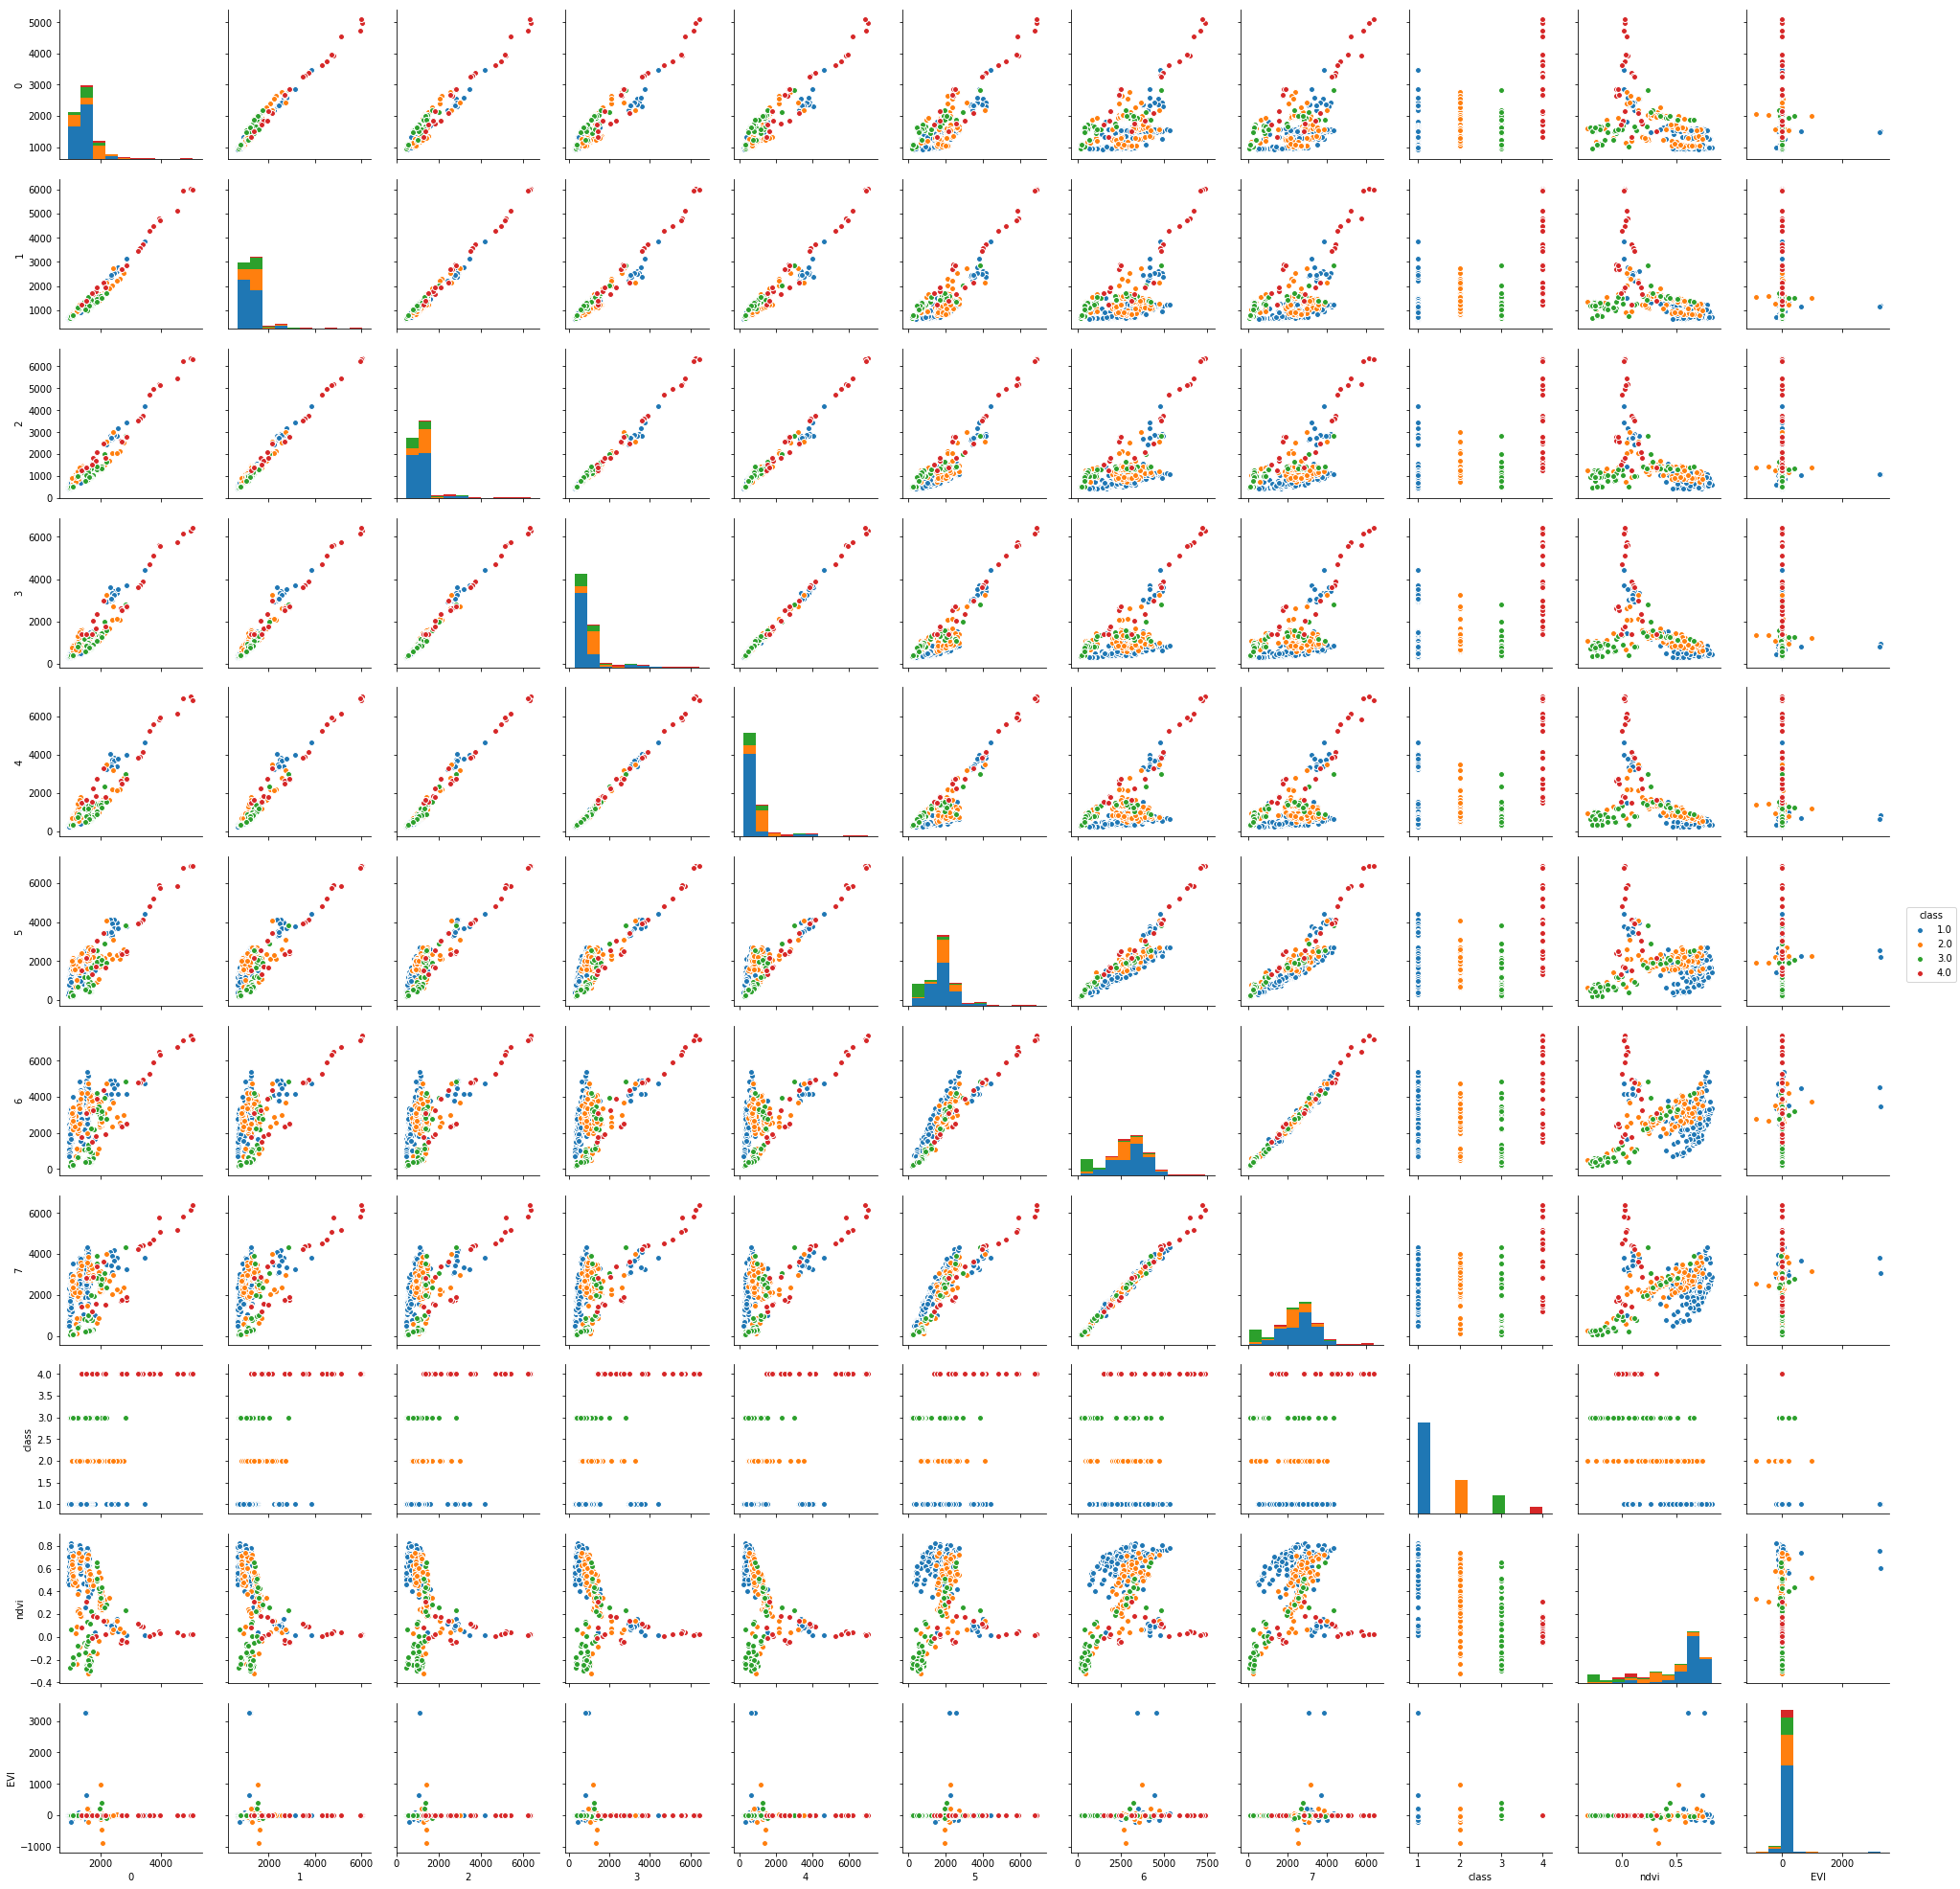

In [13]:
import seaborn as sns
sns.pairplot(data.sample(500), hue='class');

In [14]:

print label_all.shape
print data_all.T.shape

(1054320,)
(1054320, 8)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

In [16]:
from sklearn.model_selection import GridSearchCV

# initialize search space (as a library!)
param_grid = {
    'max_depth':[20,30,40],'n_estimators':[6,40]
}

# Instantiate random forest. You can specify default parameters here.
# These parameters are not being optimized.
rf = RandomForestClassifier(min_samples_leaf=2)

# initialize grid search
gs = GridSearchCV(rf, param_grid, verbose=2)#,scoring='roc_auc')

gs.fit(data.iloc[:,0:8], data['class'])

res = gs.cv_results_
tree_depth = [p['max_depth'] for p in res['params']]
n_est = [p['n_estimators'] for p in res['params']]


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=6, max_depth=20 ....................................
[CV] ..................... n_estimators=6, max_depth=20, total=   7.6s
[CV] n_estimators=6, max_depth=20 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ..................... n_estimators=6, max_depth=20, total=   7.7s
[CV] n_estimators=6, max_depth=20 ....................................
[CV] ..................... n_estimators=6, max_depth=20, total=   7.8s
[CV] n_estimators=40, max_depth=20 ...................................
[CV] .................... n_estimators=40, max_depth=20, total=  49.6s
[CV] n_estimators=40, max_depth=20 ...................................
[CV] .................... n_estimators=40, max_depth=20, total=  48.9s
[CV] n_estimators=40, max_depth=20 ...................................
[CV] .................... n_estimators=40, max_depth=20, total=  50.5s
[CV] n_estimators=6, max_depth=30 ....................................
[CV] ..................... n_estimators=6, max_depth=30, total=   8.2s
[CV] n_estimators=6, max_depth=30 ....................................
[CV] ..................... n_estimators=6, max_depth=30, total=   8.1s
[CV] n_estimators=6, max_depth=30 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.9min finished


/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


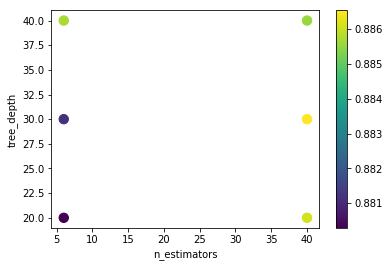

In [17]:
test_acc = res['mean_test_score']
train_acc = res['mean_train_score']
#plt.plot(tree_depth,test_acc)

plt.scatter(n_est, tree_depth,c=test_acc,s=test_acc*100)
# plt.plot(n_est, train_acc, label='train score')  # activate to also show training score

plt.xlabel('n_estimators')
plt.ylabel('tree_depth');
plt.colorbar()

# predict


In [80]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1040010031D1EC00')
bbox = env.inputs.get('bbox', '  -95.211, 29.734, -95.207, 29.737 ')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), pansharpen = False)



In [81]:
image_array = image.read()

Fetching Image... 2 tiles


In [82]:
# (8, 312, 531)
# n_b, r, c


n_bands, rows, cols = image_array.shape

n_samples = rows*cols

# image_array_flipped = np.fliplr(image_array[:,:,:])
reshaped_data = image_array.reshape(8,(rows*cols))


In [83]:
reshaped_data.T.shape

(68026, 8)

In [84]:

result = gs.predict(reshaped_data.T)
classification = result.T.T.T.reshape((rows, cols))

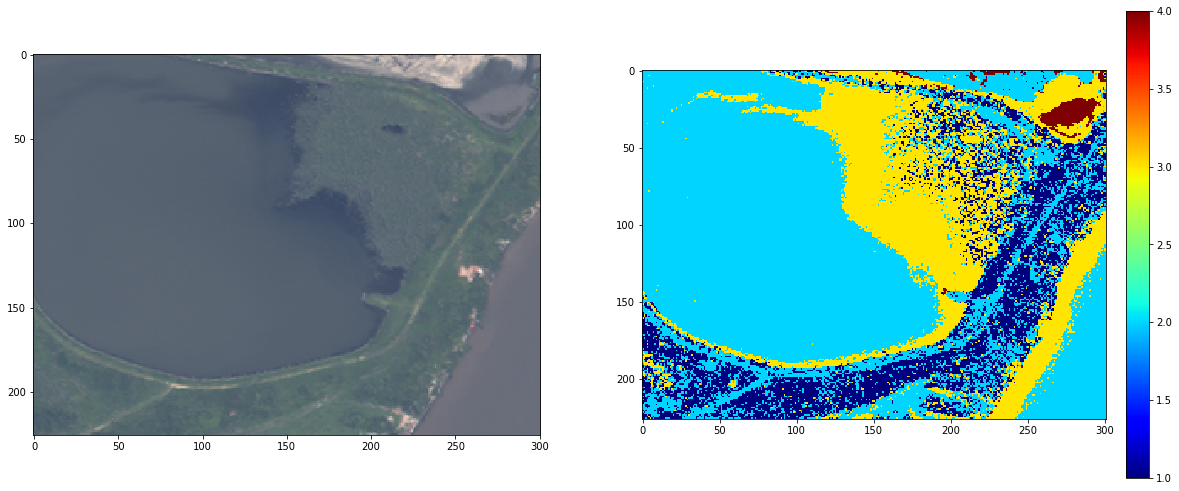

In [85]:
# dict_type = {'Forest': 1,'Wood': 1,'Nature Reserve': 1,'Wetland': 1, 'Grass': 2, 'Water': 3, 'Building': 4}
from mpl_toolkits.axes_grid1 import make_axes_locatable


from matplotlib import pyplot as plt
f = plt.figure( figsize = (20,20))
f.add_subplot(1, 2,1)
r = image_array[3,:,:]
g = image_array[2,:,:]
b = image_array[1,:,:]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/3000)
f.add_subplot(1, 2, 2)

im = plt.imshow(classification,cmap='jet')

plt.colorbar(im,fraction=0.046, pad=0.04)